In [31]:
#Imports
import pandas as pd
import numpy as np
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import Imputer
from sklearn.base import TransformerMixin
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
from sklearn import metrics

In [32]:
#Reading data files
path = r'..\Data'
filename_hr1 = path+'\\107th-112th Congress\\Bill status\\'+'HR_bill_status_contemporary.json'
filename_hr2 = path+'\\113th-114th Congress\\Bill status\\'+'HR_bill_status_modern.json'
f_hm = '..\\'+'Majority Party Chairmanships - House.csv'
f_lc = path+'\\'+'legislators-current.csv'
f_lh = path+'\\'+'legislators-historical.csv'

In [33]:
#Getting the details about the congress and which party was in majority for that bill
df_hm = pd.read_csv(f_hm)
df_hm = df_hm[['Congress', 'MajParty']]
df_hm = df_hm.drop_duplicates()

In [34]:
df_hm.head()

,Congress,MajParty
0,84,D
1,90,D
2,92,D
3,94,D
4,96,D


In [35]:
#Data preprocessing : fetching sponsors name and to which party they belong from legislators historical table
#There was a seperate fiel for full name in the data but the data was ambegiuous, therefore create the full name using the 
#other two fields present that is first name and last name
#keeping only those records where party type is rep that is house of representatives 
#And keeping only those records where party is either Republican or Democrat sinced there were many other parties as well 
# but these two are of our interest 
df_lc = pd.read_csv(f_lc)
df_lh = pd.read_csv(f_lh)
df_lh['full_name'] = df_lh['last_name'].fillna('')+', '+df_lh['first_name'].fillna('')
df_lh = df_lh[df_lh['type'] == 'rep']
df_lh = df_lh[['full_name', 'party']]
party = ["Republican", "Democrat"]
df_lh = df_lh[df_lh['party'].isin(party)]

In [36]:
#Appending the two senate files because we have collected the data from two different sources
df_hr1 = pd.read_json(filename_hr1)
df_hr2 = pd.read_json(filename_hr2)
df_hr = df_hr1.append(df_hr2, ignore_index=True)
df_hr = df_hr.fillna(np.nan)


C:\Users\cschu\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [37]:
df_hr.head()

,actions,amendments,bill_id,bill_type,by_request,committee_reports,committees,congress,cosponsors,enacted_as,...,short_title,sponsor,status,status_at,subjects,subjects_top_term,summary,titles,updated_at,url
0,"[{'acted_at': '2001-03-23', 'committee': 'Hous...","[{'amendment_id': 'h43-107', 'amendment_type':...",hr1-107,hr,NaN,NaN,"[{'activity': ['referral', 'hearings', 'markup...",107,"[{'district': '26', 'name': 'Armey, Richard K....","{'congress': '107', 'law_type': 'public', 'num...",...,No Child Left Behind Act of 2001,"{'district': '8', 'name': 'Boehner, John A.', ...",ENACTED:SIGNED,2002-01-08 00:00:00,"[AIDS (Disease), Academic performance, Accredi...",Education,"{'as': 'Conference report filed in House', 'da...","[{'as': None, 'title': 'Elementary and Seconda...",2013-02-03 01:48:02,NaN
1,"[{'acted_at': '2001-03-14', 'committee': 'Comm...","[{'amendment_id': 'h28-107', 'amendment_type':...",hr10-107,hr,NaN,NaN,"[{'activity': ['referral', 'markup', 'reportin...",107,"[{'district': '1', 'name': 'Abercrombie, Neil'...","{'congress': '107', 'law_type': 'public', 'num...",...,Railroad Retirement and Survivors' Improvement...,"{'district': '2', 'name': 'Portman, Rob', 'sta...",ENACTED:SIGNED,2001-12-21 00:00:00,"[Accidents, Accounting, Actions and defenses, ...",Labor and employment,"{'as': 'Passed Senate amended', 'date': '2001-...","[{'as': None, 'title': 'Pension Reform bill', ...",2013-02-03 01:48:03,NaN
2,"[{'acted_at': '2001-01-03', 'committee': 'Comm...",[],hr100-107,hr,NaN,NaN,"[{'activity': ['referral', 'markup', 'reportin...",107,"[{'district': '1', 'name': 'Allen, Thomas H.',...",NaN,...,National Science Education Act,"{'district': '3', 'name': 'Ehlers, Vernon J.',...",PASS_OVER:HOUSE,2001-07-30 19:49:00,"[Academic performance, Computer literacy, Comp...",Education,"{'as': 'Passed House amended', 'date': '2001-0...","[{'as': 'introduced', 'title': 'National Scien...",2013-02-03 01:48:06,NaN
3,"[{'acted_at': '2001-03-13', 'committee': 'Hous...",[],hr1000-107,hr,NaN,NaN,"[{'activity': ['referral', 'markup', 'reportin...",107,"[{'district': '1', 'name': 'Chabot, Steve', 's...","{'congress': '107', 'law_type': 'public', 'num...",...,William Howard Taft National Historic Site Bou...,"{'district': '2', 'name': 'Portman, Rob', 'sta...",ENACTED:SIGNED,2001-11-05 00:00:00,"[Boundaries, Commemorations, Ex-presidents, Go...",Public lands and natural resources,"{'as': 'Passed House amended', 'date': '2001-0...","[{'as': 'introduced', 'title': 'William Howard...",2013-02-03 01:48:33,NaN
4,"[{'acted_at': '2001-03-13', 'references': [{'r...",[],hr1001-107,hr,NaN,NaN,"[{'activity': ['referral', 'in committee'], 'c...",107,"[{'district': '9', 'name': 'Boucher, Rick', 's...",NaN,...,NaN,"{'district': '3', 'name': 'Rahall, Nick J., II...",REFERRED,2001-03-13 00:00:00,"[Collection of accounts, Estates (Law), Health...",Health,"{'as': 'Introduced', 'date': '2001-03-13', 'te...","[{'as': 'introduced', 'title': 'To amend title...",2013-02-03 01:48:33,NaN


In [38]:
# normalizingand scaling the data by creating flags 
#if there is any data in the cosponsor field taht is any non missing value make the flag 1 else 0 
#if there is non missing value in the field amendments make the flag 1 else 0
#if there is non missing value in the field  popular_title make the flag 1 else 0
#if there is non missing value in the field  related_bills make the flag 1 else 0
# creating full name for the sponsor , keeping only first and last name
df_hr['cosponsor_flg'] = np.where(df_hr['cosponsors'].apply(len)==0, 0, 1)
df_hr['amendments_flg'] = np.where(df_hr['amendments'].apply(len)==0, 0, 1)
df_hr['popular_flg'] = np.where(df_hr['popular_title'].isnull(), 0, 1)
df_hr['related_bills_flg'] = np.where(df_hr['related_bills'].apply(len)==0, 0, 1)
df_hr['sponsor_nm'] = [d.get('name') for d in df_hr.sponsor]
df_hr['full_name'] = df_hr['sponsor_nm'].str.split(' ',expand = True)[0]+' '+df_hr['sponsor_nm'].str.split(' ',expand = True)[1] 
df_hr['Congress'] = pd.to_numeric(df_hr['congress'], errors='coerce')

In [39]:
#merging files on sponsor names and congress

df_hr1 = pd.merge(df_hr, df_lh, how='inner', on=['full_name'])
df_hr2 = pd.merge(df_hr1, df_hm, how='inner', on=['Congress'])

df_hr2 = df_hr2[df_hr2['party'].isin(party)]
df_hr2['party_flg'] = np.where(df_hr2['party'] == "Republican", 0, 1)
df_hr2['majority_flg'] = np.where(df_hr2['MajParty'] == "R", 0, 1)

statuses = ['INTRODUCED','REFERRED']
df_hr2['Class'] = np.where(df_hr2['status'].isin(statuses), 0, 1)


In [40]:
#Final Feature selection
#our class field is Status
df_hr = df_hr2[['bill_id', 'cosponsor_flg','amendments_flg', 'popular_flg', 'related_bills_flg', 'party_flg', 'majority_flg', 'Class']]
df_hr = df_hr.reset_index(drop = True)


In [41]:
#taking 80% training datafeatures = list(df_hr.columns[1:7])
features = list(df_hr.columns[1:7])
traindatasize = int(len(df_hr)*.8)
testdatasize = len(df_hr) - traindatasize

In [42]:
#assigning data for tarining and test
traindata = df_hr[0:traindatasize]
testdata = df_hr[traindatasize:len(df_hr)+1]


df2 = traindata
y_train = df2["Class"]
X_train = df2[features]

df3 = testdata
y_test = df3["Class"]
X_test = df3[features]

# Random Forest
***

In [43]:
#applying random forest 
rf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
rf.fit(X_train, y_train)
y_predicted_rf = rf.predict(X_test)
y_score_rf = rf.score(X_test,y_test)

y_score_rf

0.8868552412645591

In [44]:
#Classification report
print(classification_report_imbalanced(y_test, y_predicted_rf))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      1.00      0.16      0.94      0.41      0.18      4157
          1       1.00      0.16      1.00      0.28      0.41      0.15       651

avg / total       0.90      0.89      0.28      0.85      0.41      0.17      4808



In [45]:
#Confusion matrix
print(confusion_matrix(y_test, y_predicted_rf))

[[4157    0]
 [ 544  107]]


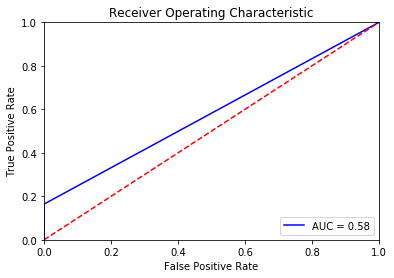

In [46]:
#ROC curve


# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, y_predicted_rf)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Decision Tree
***

In [47]:
#applying decision tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_predicted = dt.predict(X_test)
y_score = dt.score(X_test,y_test)

y_score

0.8868552412645591

In [48]:
#Classification report
print(classification_report_imbalanced(y_test, y_predicted))


                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      1.00      0.16      0.94      0.41      0.18      4157
          1       1.00      0.16      1.00      0.28      0.41      0.15       651

avg / total       0.90      0.89      0.28      0.85      0.41      0.17      4808



In [49]:
#Confusion matrix
print(confusion_matrix(y_test, y_predicted))

[[4157    0]
 [ 544  107]]


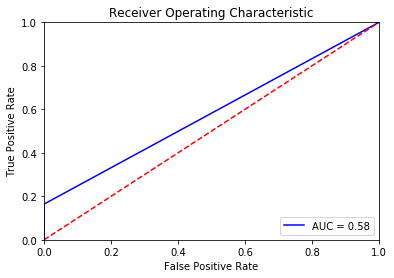

In [50]:
#ROC curve


# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, y_predicted)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# SVM
***

In [51]:
#applying SVM
d_svm = svm.SVC()
d_svm.fit(X_train, y_train)
y_predicted_svm = d_svm.predict(X_test)
y_score_svm = d_svm.score(X_test,y_test)

y_score_svm

C:\Users\cschu\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.8868552412645591

In [52]:
#Classification report
print(classification_report_imbalanced(y_test, y_predicted_svm))


                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      1.00      0.16      0.94      0.41      0.18      4157
          1       1.00      0.16      1.00      0.28      0.41      0.15       651

avg / total       0.90      0.89      0.28      0.85      0.41      0.17      4808



In [53]:
#Confusion matrix
print(confusion_matrix(y_test, y_predicted_svm))

[[4157    0]
 [ 544  107]]


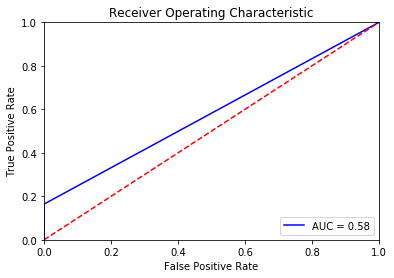

In [54]:
#ROC curve


# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, y_predicted_svm)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [57]:
#converting data into csv for visualization 
df_hr.to_csv(path+'hr_viz.csv')